In [5]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Conv2D, BatchNormalization, Activation, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Define constants and hyperparameters
CONFIG = {
    'INPUT_IMAGE_SIZE': (71, 71),
    'TRAIN_BATCH_SIZE': 64,
    'TEST_BATCH_SIZE': 64,
    'EPOCHS': 15,
    'LEARNING_RATE': 0.001,
    'NUM_CLASSES': 7,
}

# Define the transfer learning model using Xception with added attention mechanism
def create_transfer_model(input_shape, num_classes):
    base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = True  # Fine-tune the entire model

    # Ensure the attention layer has the same number of filters as the base model output
    num_filters = base_model.output.shape[-1]

    # Add attention mechanism
    attention_layer = Conv2D(num_filters, kernel_size=(1, 1), padding='same')(base_model.output)
    attention_layer = BatchNormalization()(attention_layer)
    attention_layer = Activation('sigmoid')(attention_layer)
    attention_layer = Multiply()([base_model.output, attention_layer])

    x = GlobalAveragePooling2D()(attention_layer)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs)

    # Use Adam optimizer
    optimizer = Adam(learning_rate=CONFIG['LEARNING_RATE'])
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Calculate class weights to handle class imbalance
def calculate_class_weights(train_dir):
    class_weights = {}
    class_indices = {}
    for root, dirs, files in os.walk(train_dir):
        labels = [d for d in dirs if os.path.isdir(os.path.join(root, d))]
        if labels:
            break
    class_indices = dict(zip(labels, range(len(labels))))

    # Compute the class weight for each class
    weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
    for class_name, class_index in class_indices.items():
        class_weights[class_index] = weights[class_index]

    return class_weights

# Load and preprocess the data
def load_data(train_dir, test_dir, img_size, train_batch_size, test_batch_size):
    # Increased data augmentation for the training set
    train_datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    test_datagen = ImageDataGenerator(rescale=1.0/255.0)

    train_data = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        color_mode='rgb',
        batch_size=train_batch_size,
        class_mode='categorical',
        shuffle=True
    )

    test_data = test_datagen.flow_from_directory(
        test_dir,
        target_size=img_size,
        color_mode='rgb',
        batch_size=test_batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_data, test_data

# Define callbacks
def create_callbacks():
    log_dir = "logs/fit/xception_" + datetime.now().strftime("%Y%m%d-%H%M%S")
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1),
        ModelCheckpoint('best_xception_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1),
        TensorBoard(log_dir=log_dir, histogram_freq=1)
    ]
    return callbacks

# Function to train and evaluate the model
def train_and_evaluate_model(model, train_data, test_data, epochs, callbacks, class_weights):
    history = model.fit(
        train_data,
        epochs=epochs,
        validation_data=test_data,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )
    return history

# Function to plot training and validation metrics
def plot_metrics(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(accuracy))

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, accuracy, label='Training Accuracy')
    plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# Function to evaluate the model and display classification metrics
def evaluate_model(model, test_data):
    test_loss, test_accuracy = model.evaluate(test_data, verbose=0)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    predictions = model.predict(test_data, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_data.classes
    class_labels = list(test_data.class_indices.keys())

    print("Classification Report:")
    print(classification_report(true_classes, predicted_classes, target_names=class_labels))

    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='g', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Epoch 1/10
449/449 [==============================] - ETA: 0s - loss: 1.3767 - accuracy: 0.4772
Epoch 1: val_accuracy improved from -inf to 0.54556, saving model to best_xception_model.keras
449/449 [==============================] - 395s 841ms/step - loss: 1.3767 - accuracy: 0.4772 - val_loss: 1.2987 - val_accuracy: 0.5456 - lr: 0.0010
Epoch 2/10
449/449 [==============================] - ETA: 0s - loss: 1.1603 - accuracy: 0.5687
Epoch 2: val_accuracy improved from 0.54556 to 0.58679, saving model to best_xception_model.keras
449/449 [==============================] - 353s 785ms/step - loss: 1.1603 - accuracy: 0.5687 - val_loss: 1.1805 - val_accuracy: 0.5868 - lr: 0.0010
Epoch 3/10
449/449 [==============================] - ETA: 0s - loss: 1.0812 - accuracy: 0.5994
Epoch 3: val_accuracy improved from 0.58679 to 0.60267, saving model to best_xception_model.keras
449/449 [==============================]

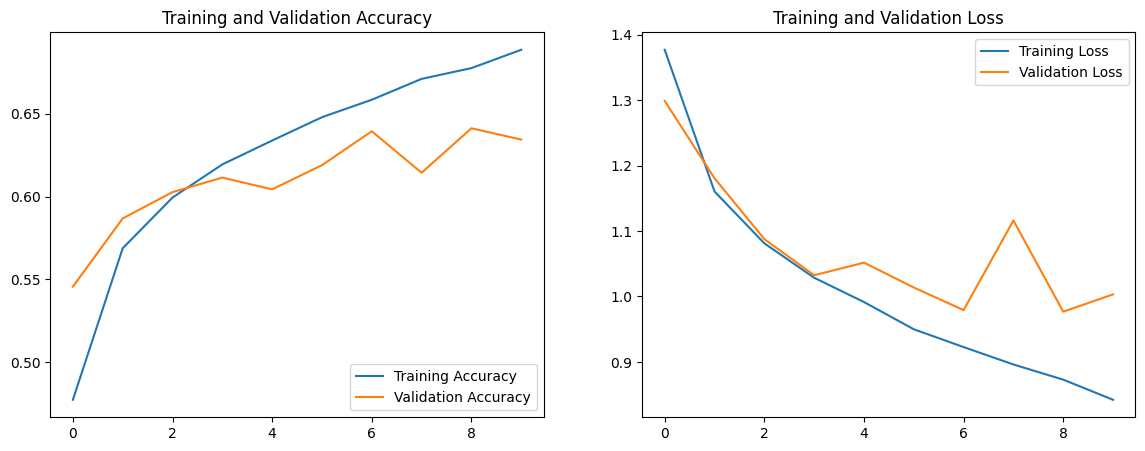

Test Loss: 1.0032, Test Accuracy: 0.6344
Classification Report:
              precision    recall  f1-score   support

       angry       0.57      0.57      0.57       958
     disgust       0.59      0.46      0.52       111
        fear       0.51      0.33      0.40      1024
       happy       0.86      0.86      0.86      1774
     neutral       0.54      0.58      0.56      1233
         sad       0.48      0.55      0.51      1247
    surprise       0.73      0.84      0.78       831

    accuracy                           0.63      7178
   macro avg       0.61      0.60      0.60      7178
weighted avg       0.63      0.63      0.63      7178



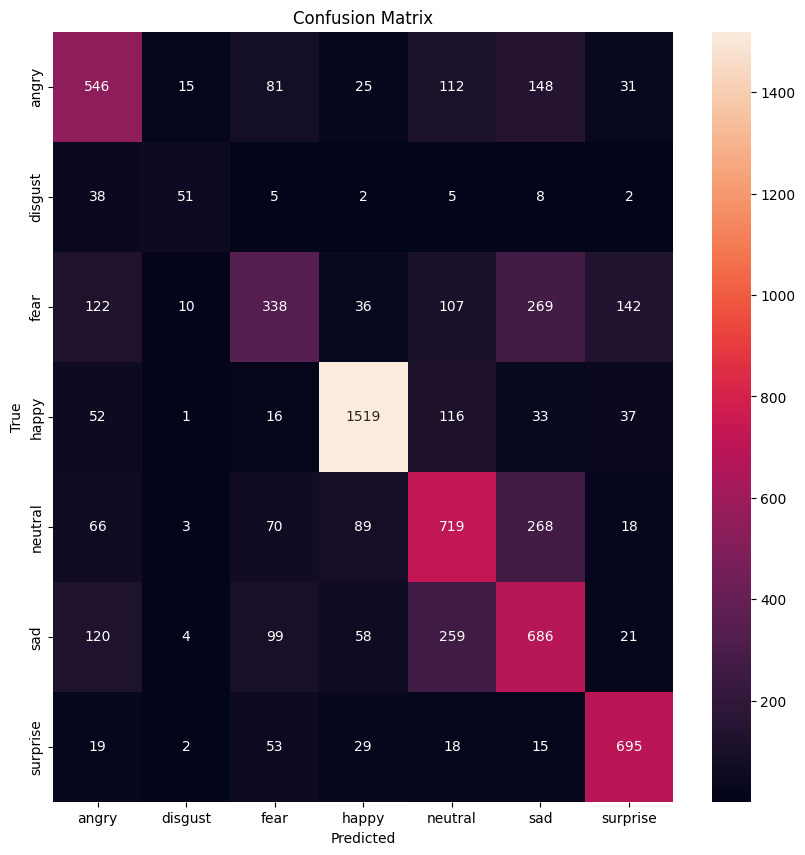

d:\git\MLOps\Fraud-Detection-System-MLOps\fraudEnv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [6]:
train_dir = 'data/train'
test_dir = 'data/test'

train_data, test_data = load_data(
    train_dir,
    test_dir,
    img_size=CONFIG['INPUT_IMAGE_SIZE'],
    train_batch_size=CONFIG['TRAIN_BATCH_SIZE'],
    test_batch_size=CONFIG['TEST_BATCH_SIZE']
)

class_weights = calculate_class_weights(train_dir)

model = create_transfer_model(input_shape=(*CONFIG['INPUT_IMAGE_SIZE'], 3), num_classes=CONFIG['NUM_CLASSES'])
callbacks = create_callbacks()
history = train_and_evaluate_model(model, train_data, test_data, CONFIG['EPOCHS'], callbacks, class_weights)
plot_metrics(history)
evaluate_model(model, test_data)
model.save('xception_model.h5')
